# Classification

### Import

In [1]:
import os
import sys
import matplotlib.pyplot as plt


from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import  DataLoader

from tqdm import tqdm
from sklearn.metrics import accuracy_score

### Configuration

In [2]:
sys.path.append('..')  # Replace '..' with the actual path to the parent directory containing 'src'.

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print(device)

cuda


In [3]:
from objects.dataset import McGillDataset, CustomDataset
from objects.utils import split_dataset, split_dataset_1
from objects.models import Classifier

In [4]:
# Example usage:
root_dir = '../data'
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor()
    #transforms.Lambda(lambda x: x[:3, :, :]),  # Keep only the first three channels (R, G, B)
])

# Create an instance of the McGillDataset class for Ply files
dataset = McGillDataset(root_dir, file_type='Ply')
dataset.class_to_idx

{'crabs': 0,
 'snakes': 1,
 'spiders': 2,
 'spectacles': 3,
 'pliers': 4,
 'teddy': 5,
 'humans': 6,
 'hands': 7,
 'ants': 8,
 'octopuses': 9}

In [5]:
train_set, test_set = split_dataset(dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [64]:
train_set.dataset.class_to_idx

{'crabs': 0,
 'snakes': 1,
 'spiders': 2,
 'spectacles': 3,
 'pliers': 4,
 'teddy': 5,
 'humans': 6,
 'hands': 7,
 'ants': 8,
 'octopuses': 9}

In [65]:
train_set[0]

{'path_3d_data_file': '../data/humans/humansPly/b14.ply',
 'path_2d_data_folder': '../data/humans/humansImage2D/b14',
 'label': 6}

In [66]:
# Initialize the classifier
num_classes = len(dataset.categories)

classifier = Classifier(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 10

/home/yannt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yannt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
train_loader.dataset.dataset.class_to_idx

{'crabs': 0,
 'snakes': 1,
 'spiders': 2,
 'spectacles': 3,
 'pliers': 4,
 'teddy': 5,
 'humans': 6,
 'hands': 7,
 'ants': 8,
 'octopuses': 9}

In [32]:
# Lists to store training and test loss, and training and test accuracy values
train_loss_values = []
train_accuracy_values = []
test_loss_values = []
test_accuracy_values = []

# Training and testing loop
for epoch in tqdm(range(num_epochs)):
    # Training phase
    classifier.train()  # Set the model to training mode
    running_loss = 0.0
    predictions = []
    true_labels = []

    for batch in tqdm(train_loader, desc="Processing batches"):
        path_images_folders = batch['path_2d_data_folder']
        labels = batch['label'].to(device)

        for i in range(36):
            images = []
            for folder in path_images_folders:
                path_image = os.listdir(folder)[i]
                img = transform(Image.open(os.path.join(folder ,path_image)).convert('RGB'))
                images.append(img)
            #print(path_image)
            images = torch.stack(images).to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = classifier(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            
            
    # Calculate training accuracy
    train_accuracy = accuracy_score(true_labels, predictions)

    # Store training loss and accuracy values
    train_loss_values.append(running_loss / len(train_loader))
    train_accuracy_values.append(train_accuracy)

    # Print training loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss_values[-1]}, Training Accuracy: {train_accuracy * 100:.2f}%")
        



 10%|█         | 1/10 [02:02<18:23, 122.60s/it]

Epoch 1/10, Training Loss: 14.560580337686199, Training Accuracy: 86.98%


 20%|██        | 2/10 [03:47<14:57, 112.20s/it]

Epoch 2/10, Training Loss: 10.671463276126556, Training Accuracy: 90.32%


 30%|███       | 3/10 [04:18<08:45, 75.04s/it] 

Epoch 3/10, Training Loss: 11.235597995010071, Training Accuracy: 90.14%


 40%|████      | 4/10 [04:49<05:46, 57.71s/it]

Epoch 4/10, Training Loss: 9.220378431341876, Training Accuracy: 92.69%


 50%|█████     | 5/10 [05:20<04:00, 48.11s/it]

Epoch 5/10, Training Loss: 8.240686457504385, Training Accuracy: 93.30%


 60%|██████    | 6/10 [05:52<02:50, 42.51s/it]

Epoch 6/10, Training Loss: 7.8247098354040645, Training Accuracy: 93.25%


 70%|███████   | 7/10 [06:23<01:56, 38.97s/it]

Epoch 7/10, Training Loss: 3.136886305828479, Training Accuracy: 96.92%


 80%|████████  | 8/10 [06:55<01:13, 36.59s/it]

Epoch 8/10, Training Loss: 3.681399527195026, Training Accuracy: 96.77%


 90%|█████████ | 9/10 [07:27<00:35, 35.04s/it]

Epoch 9/10, Training Loss: 3.483855640844143, Training Accuracy: 96.87%


100%|██████████| 10/10 [07:58<00:00, 47.88s/it]

Epoch 10/10, Training Loss: 4.4403699666810486, Training Accuracy: 96.31%


In [68]:
from sklearn.metrics import accuracy_score

# Assuming you have a separate test_loader for your test dataset

for epoch in tqdm(range(num_epochs)):
    # Training phase
    classifier.train()  # Set the model to training mode
    running_loss = 0.0
    predictions = []
    true_labels = []

    for batch in tqdm(train_loader, desc="Processing batches"):
        path_images_folders = batch['path_2d_data_folder']
        labels = batch['label'].to(device)

        for i in range(36):
            images = []
            for folder in path_images_folders:
                path_image = os.listdir(folder)[i]
                img = transform(Image.open(os.path.join(folder, path_image)).convert('RGB'))
                images.append(img)
                
            images = torch.stack(images).to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = classifier(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(true_labels, predictions)

    # Store training loss and accuracy values
    train_loss_values.append(running_loss / len(train_loader))
    train_accuracy_values.append(train_accuracy)

    # Print training loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss_values[-1]}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # Testing phase
    classifier.eval()  # Set the model to evaluation mode
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for test_batch in tqdm(test_loader, desc="Testing batches"):
            path_images_folders = test_batch['path_2d_data_folder']
            labels = test_batch['label'].to(device)

            for i in range(36):
                images = []
                for folder in path_images_folders:
                    path_image = os.listdir(folder)[i]
                    img = transform(Image.open(os.path.join(folder, path_image)).convert('RGB'))
                    images.append(img)

                images = torch.stack(images).to(device)

                outputs = classifier(images)
                _, predicted = torch.max(outputs.data, 1)
                test_predictions.extend(predicted.cpu().numpy())
                test_true_labels.extend(labels.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Print test accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {test_accuracy * 100:.2f}%")


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.44s/it]


Epoch 1/10, Training Loss: 16.93469254273389, Training Accuracy: 84.20%


 10%|█         | 1/10 [00:35<05:20, 35.56s/it]

Epoch 1/10, Test Accuracy: 49.46%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.51s/it]


Epoch 2/10, Training Loss: 11.586882325354964, Training Accuracy: 89.68%


 20%|██        | 2/10 [01:11<04:44, 35.60s/it]

Epoch 2/10, Test Accuracy: 54.96%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.55s/it]


Epoch 3/10, Training Loss: 10.513237239393805, Training Accuracy: 92.05%


 30%|███       | 3/10 [01:47<04:10, 35.75s/it]

Epoch 3/10, Test Accuracy: 28.70%


Processing batches: 100%|██████████| 7/7 [00:32<00:00,  4.67s/it]


Epoch 4/10, Training Loss: 12.157887572655454, Training Accuracy: 90.16%


 40%|████      | 4/10 [02:24<03:37, 36.20s/it]

Epoch 4/10, Test Accuracy: 71.19%


Processing batches: 100%|██████████| 7/7 [00:32<00:00,  4.57s/it]


Epoch 5/10, Training Loss: 5.161965895676985, Training Accuracy: 95.04%


 50%|█████     | 5/10 [03:00<03:00, 36.16s/it]

Epoch 5/10, Test Accuracy: 69.66%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.56s/it]


Epoch 6/10, Training Loss: 6.152201603582528, Training Accuracy: 94.74%


 60%|██████    | 6/10 [03:36<02:24, 36.07s/it]

Epoch 6/10, Test Accuracy: 80.28%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.54s/it]


Epoch 7/10, Training Loss: 3.515054638297962, Training Accuracy: 96.84%


 70%|███████   | 7/10 [04:11<01:47, 35.99s/it]

Epoch 7/10, Test Accuracy: 68.63%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.55s/it]


Epoch 8/10, Training Loss: 5.06352989718185, Training Accuracy: 95.72%


 80%|████████  | 8/10 [04:47<01:11, 35.94s/it]

Epoch 8/10, Test Accuracy: 69.01%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.54s/it]


Epoch 9/10, Training Loss: 3.3006581503161994, Training Accuracy: 96.83%


 90%|█████████ | 9/10 [05:23<00:35, 35.95s/it]

Epoch 9/10, Test Accuracy: 78.92%


Processing batches: 100%|██████████| 7/7 [00:31<00:00,  4.53s/it]


Epoch 10/10, Training Loss: 2.6314030727496305, Training Accuracy: 97.63%


100%|██████████| 10/10 [05:59<00:00, 35.96s/it]

Epoch 10/10, Test Accuracy: 72.98%


In [13]:
#torch.save(classifier.state_dict(), "../models/resnet.pth")

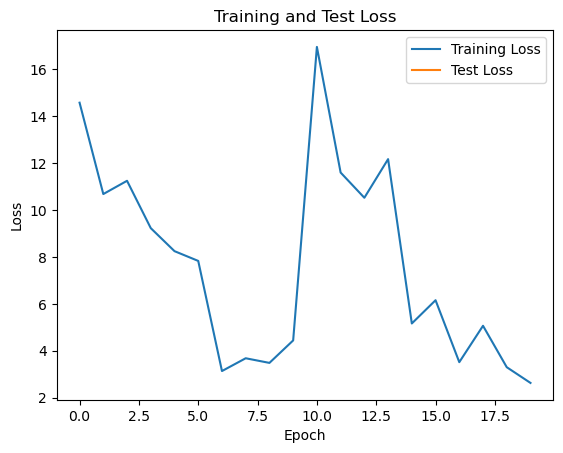

In [69]:
# Plot the learning curves
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

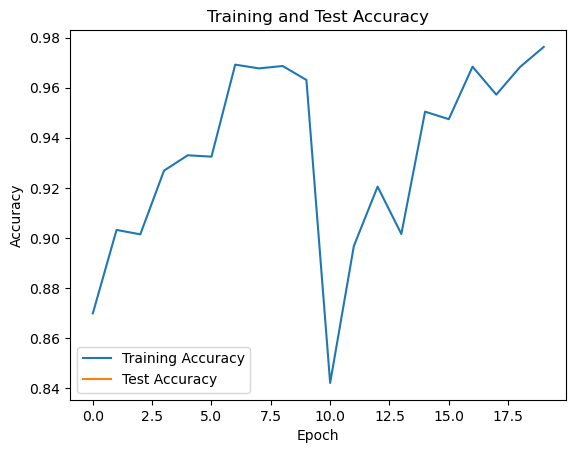

In [70]:
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

In [5]:
# Example usage:
root_directory = '../2d_data'
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

custom_dataset = CustomDataset(root_directory, transform=transform)

train_set, test_set = split_dataset_1(custom_dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [6]:
model = Classifier(10)

# Load the model weights
model_path = '../models/resnet18.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

/home/yannt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yannt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [8]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Accuracy on the test set: 83.02%
